# Simple Regression and Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gumbi as gmb

Use gumbi' plotting defaults for stylistic consistency, good dataviz practice, and aesthetics

In [2]:
plt.style.use(gmb.style.default)

## Setup

Load in a DataFrame and store as a DataSet:

In [3]:
df = pd.read_pickle(gmb.data.example_dataset).query('Metric=="mean"')
outputs=['a', 'b', 'c', 'd', 'e', 'f']
log_vars=['Y', 'b', 'c', 'd', 'f']
logit_vars=['X', 'e']
ds = gmb.DataSet(df, outputs=outputs, log_vars=log_vars, logit_vars=logit_vars)
ds.tidy = ds.tidy[ds.tidy.Color.isin(['cyan', 'magenta']) & (ds.tidy.Pair == 'burrata+barbaresco')]

## Building and fitting a model

Build and fit a GP model with linear + RBF kernels for each of `X`, `Y`, and log `Z`:

In [4]:
gp = gmb.GP(ds, outputs=['d'])
gp.fit(continuous_dims=['X', 'Y', 'lg10_Z'], linear_dims=['X', 'Y', 'lg10_Z']);

## Making predictions

Predict at a single point using a ParameterArray. Note that you can build a `parray` using a method from the `GP` object; this is a convenience method that allows the `parray` to inherit `gp`'s `stdzr` instance.

The result is an UncertainParameterArray containing the mean and variance of the prediction:

In [5]:
point = gp.parray(lg10_Z=8, X=0.5, Y=88)
pred = gp.predict_points(point)
pred

d['μ', 'σ2']: [(0.76400657, 0.0017301)]

You can predict over a range of values for a given dimension while specifying a specific value for the remaining dimensions. The result is an UncertainParameterArray containing the mean and variance at each point:

In [6]:
gp.prepare_grid(at=gp.parray(lg10_Z=8, X=0.5))
gp.predict_grid()
x_pa = gp.predictions_X['Y']
y_upa = gp.predictions
y_upa[:10]

d['μ', 'σ2']: [(0.88101267, 0.03874863) (0.88022272, 0.03582379)
 (0.88016288, 0.03267722) (0.88087374, 0.02936242)
 (0.88238142, 0.02595123) (0.8846935 , 0.02253084)
 (0.88779484, 0.01919837) (0.89164386, 0.01605362)
 (0.89616929, 0.01319035) (0.90126805, 0.01068745)]

## Visualizing predictions

`ParrayPlotter` provides a convenient way to plot structured arrays and switch between natural, transformed, and standardized views and/or tick labeling for any dimension. By default, all arrays are plotted and labeled in "natural" space:

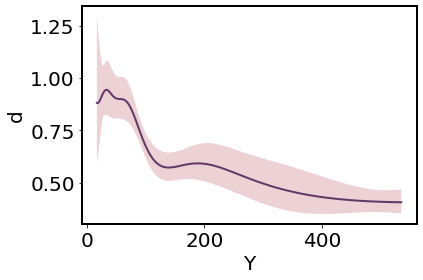

In [7]:
pp = gmb.ParrayPlotter(x_pa, y_upa)
pp.plot();

Arrays can be viewed in "standardized" or "transformed" space by passing those values as the respective *&ast;_scale* argument. By default, the array the tick labels remain in "natural" space unless an alternative is specified as the corresponding *&ast;_tick_scale* argument.

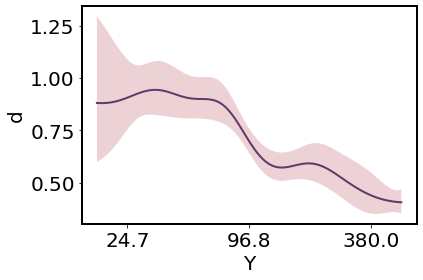

In [8]:
pp = gmb.ParrayPlotter(x_pa, y_upa, x_scale='standardized')
# pp = gmb.ParrayPlotter(x_pa.z, y_upa)  # equivalent
pp.plot();

The same `ParrayPlotter` instance can be reused to produce an alternative view of the data. Simply call `pp.update()` after changing the *&ast;_scale* or *&ast;_tick_scale* attributes.

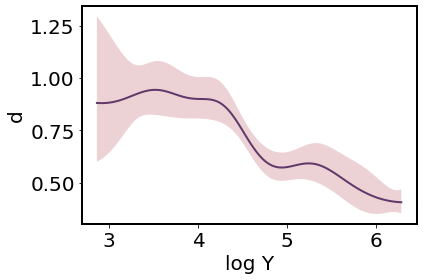

In [9]:
pp.x_scale = 'transformed'
pp.x_tick_scale = 'transformed'
pp.update()
# pp = gmb.ParrayPlotter(x_pa.t, y_upa, x_tick_scale = 'transformed')  #equiv
pp.plot();

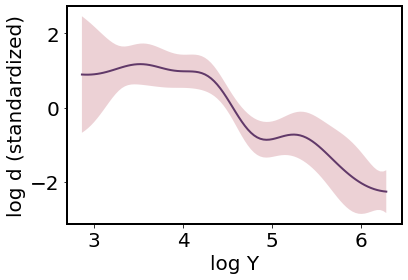

In [10]:
pp.y_scale = 'standardized'
pp.y_tick_scale = 'standardized'
pp.update()
pp.plot();

### Marginalizing

The UncertainParameterArray allows marginalization with uncertainty propagation:

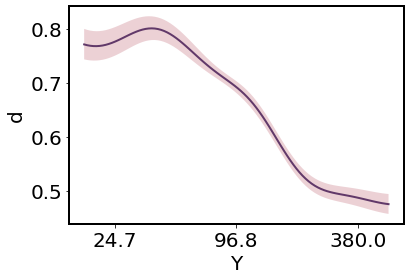

In [11]:
gp.prepare_grid(at=gp.parray(lg10_Z=8))
gp.predict_grid();

x_pa = gp.grid_vectors['Y'].squeeze()
y_upa = gp.predictions.mean(axis=gp.prediction_dims.index('X'))

ax = gmb.ParrayPlotter(x_pa.z, y_upa).plot()

## Higher-dimensional predictions and slicing

In most cases you'll want to simply predict over a lower-dimensional set of points if that's your goal, but sometimes you may wish to make a high-dimensional prediction and view lower-dimensional slices. The `get_conditional_prediction` method performs interpolation on the higher-dimensional prediction, returning a *ParameterArray* containing the lower-dimensional domain and an *UncertainParameterArray* containing the predictions at those points.

To demonstrate, first make predictions across a large grid:

In [12]:
gp.prepare_grid(resolution={'Y':100, 'X':100, 'lg10_Z': 21})

gp.predict_grid();

In addition to the `.plot` method shown above, a *ParrayPlotter* can be called on any function, typically a matplotlib function, to pass appropriately-formatted ndarrays as positional arguments along with any additional keyword arguments. This allows you to quickly iterate on different visualizations with minimal repetition.

Now plot a 2D slice of the predictions, specifically the predictions across `X` and `Y` at a `Z` of 10^8:

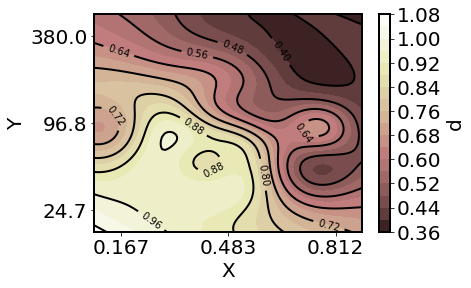

In [13]:
xy_pa, z_upa = gp.get_conditional_prediction(lg10_Z=8)
x_pa, y_pa = xy_pa.as_list()

pp = gmb.ParrayPlotter(x_pa.z, y_pa.z, z_upa)

# Make a filled contour plot by calling ParrayPlotter on the matplotlib function and passing kwargs
cs = pp(plt.contourf, cmap='pink', levels=20)

# Add an appropriately scaled and labeled colorbar
cbar = pp.colorbar(cs);

# Add a few contour outlines
cl = pp(plt.contour, colors='k', levels=10)
ax.clabel(cl, inline=True, fontsize=10);

Or 1D slices:

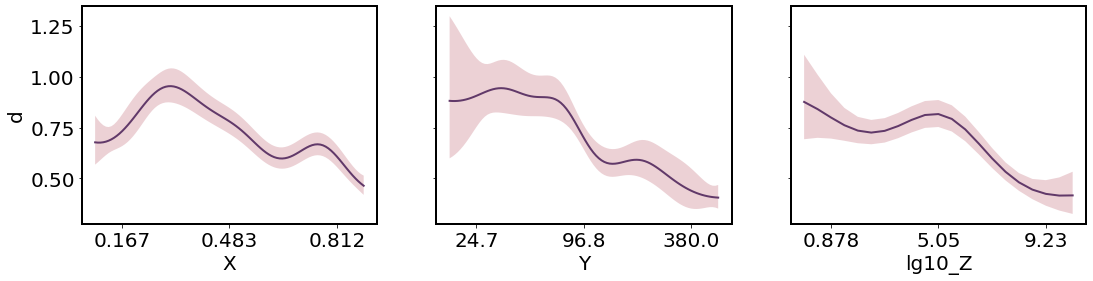

In [14]:
axs = plt.subplots(1,3, figsize=(18,4), sharey=True)[1]

x_pa, y_upa = gp.get_conditional_prediction(Y=88, lg10_Z=8.)
gmb.ParrayPlotter(x_pa.z, y_upa).plot(ax=axs[0])

x_pa, y_upa = gp.get_conditional_prediction(X=0.5, lg10_Z=8.)
gmb.ParrayPlotter(x_pa.z, y_upa).plot(ax=axs[1])
axs[1].set_ylabel('')

x_pa, y_upa = gp.get_conditional_prediction(X=0.85, Y=88)
gmb.ParrayPlotter(x_pa.z, y_upa).plot(ax=axs[2])
axs[2].set_ylabel('');